Лабораторная работа №3, гр. 2371, Войтко Д.А.

1. https://www.kaggle.com/datasets/arpitsinghaiml/world-population - выбранный датасет для выполнения лабораторной работы.


Подключим необходимые для работы библиотеки:

In [92]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import matplotlib.pyplot as plt

Далее выведем выбранный датасет и проведем некоторые операции по его "шлифованию".

In [93]:
dframe = pd.read_csv('countries-table.csv') # Чтение датасета

dframe = dframe.drop(dframe.columns[[8, 11, 12, 13]], axis=1) # Исключаем ненужные колонки, содержащие текст

dframe = dframe.fillna(dframe.mean()) # Удаляем пропущенные значения

print(dframe.head()) # Выведем строки датасета

   place    pop1980     pop2000     pop2010     pop2023     pop2024  \
0    356  687354000  1057920000  1243480000  1438070000  1450940000   
1    156  983164000  1269580000  1351560000  1422580000  1419320000   
2    840  229859000   281484000   311063000   343477000   345427000   
3    360  148951000   216078000   246305000   281190000   283488000   
4    586   82291000   154879000   199239000   247504000   251269000   

      pop2030     pop2050       area  landAreaKm  netChange  growthRate  \
0  1525140000  1679590000  3287590.0   2973190.0     0.4119      0.0089   
1  1398150000  1260290000  9706961.0   9424702.9    -0.1006     -0.0023   
2   355650000   380847000  9372610.0   9147420.0     0.0600      0.0057   
3   295877000   320713000  1904569.0   1877519.0     0.0719      0.0082   
4   276883000   371864000   881912.0    770880.0     0.1225      0.0152   

   worldPercentage   density  densityMi  rank  
0           0.1813  488.0078  1263.9403     1  
1           0.1773  150.59

Теперь выберем столбец-атрибут, который выступит в роли целевого класса: landAreaKm.
Страны, которые на основе датасета в столбце landAreaKm (Площадь страны в км кв.) имеют значение > 500000 будут считаться большими (1), а те, у кого меньше этого числа - небольшие (0).

In [94]:

dframe['AreaKm_binary'] = dframe['landAreaKm'].apply(lambda x: 1 if x > 500000 else 0)   # Создаем бинарную переменную

X = dframe.drop(columns = ['landAreaKm', 'AreaKm_binary'])
y = dframe['AreaKm_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify=y) # Разделение данных на обучающую и тестовую выборки (30% данных будут отведены под тестовую выборку, а оставшиеся 70% - под обучающую выборку.)

Теперь взглянем на полученные классы (1 и 0). Как мы можем увидеть - получается довольно большая разница.

In [95]:
dframe['AreaKm_binary'].value_counts()

AreaKm_binary
0    184
1     50
Name: count, dtype: int64

Далее будем применять метод увеличения числа случаев в наборе данных, для того, чтобы исправить сбалансированность - SMOTE. (Метод синтетической передискретизации меньшинства (SMOTE) — это статистический метод для сбалансированного увеличения числа наблюдений в вашем наборе данных)

In [ ]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
scaler = StandardScaler()
X_train_smote = scaler.fit_transform(X_train_smote)
X_test = scaler.transform(X_test)

Далее идет обучение моделей kNN и "дерево решений" ("Decision tree") и их дальнейшее сравнение. 

In [100]:
knn = KNeighborsClassifier(n_neighbors=2)
decision_tree = DecisionTreeClassifier(random_state=42)

knn.fit(X_train_smote, y_train_smote)
y_pred_knn_smote = knn.predict(X_test)

decision_tree.fit(X_train_smote, y_train_smote)
y_pred_tree_smote = decision_tree.predict(X_test)

Выведем результат.

In [101]:
print(classification_report(y_test, y_pred_knn_smote))
print(classification_report(y_test, y_pred_tree_smote))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93        56
           1       0.89      0.53      0.67        15

    accuracy                           0.89        71
   macro avg       0.89      0.76      0.80        71
weighted avg       0.89      0.89      0.88        71

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        56
           1       0.93      0.93      0.93        15

    accuracy                           0.97        71
   macro avg       0.96      0.96      0.96        71
weighted avg       0.97      0.97      0.97        71



Далее сравним полученные результаты с помощью метрики качества ROC-кривой.

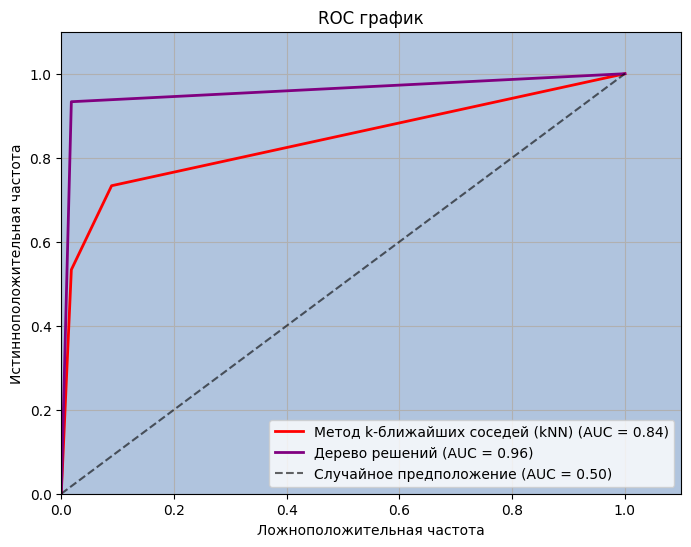

In [126]:
# Построим ROC-кривую.
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Получение вероятностей
y_prob_knn = knn.predict_proba(X_test)[:, 1]
y_prob_tree = decision_tree.predict_proba(X_test)[:, 1]

# Вычисление ROC и AUC
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_prob_tree)

roc_auc_knn = auc(fpr_knn, tpr_knn)
roc_auc_tree = auc(fpr_tree, tpr_tree)

# Построение графика
plt.figure(figsize=(8, 6))
plt.gca().set_facecolor('lightsteelblue')
plt.xlim(0, 1.1)
plt.ylim(0, 1.1)
plt.plot(fpr_knn, tpr_knn, color='red', label=f"Метод k-ближайших соседей (kNN) (AUC = {roc_auc_knn:.2f})", linewidth=2)
plt.plot(fpr_tree, tpr_tree, color='purple', label=f"Дерево решений (AUC = {roc_auc_tree:.2f})", linewidth=2)
plt.plot([0, 1], [0, 1], color='black', label="Случайное предположение (AUC = 0.50)", alpha=0.6, linestyle='dashed')
plt.title("ROC график")
plt.xlabel("Ложноположительная частота")
plt.ylabel("Истинноположительная частота")
plt.legend(loc="lower right")
plt.grid()
plt.show()

Вывод:
Класс - Небольшие страны (0):
kNN: precision = 0.89, recall = 0.98, f-score = 0.93
Дерево решений: precision = 0.98, recall = 0.98, f-score = 0.98
Значение f-score указывает на то, что дерево решений имеет более сбалансированное поведение, а также, судя по другим параметрам kNN явно ему уступает.
Класс - Большие страные (1):
kNN: precision = 0.89, recall = 0.53, f-score = 0.67
Дерево решений: precision = 0.93, recall = 0.93, f-score = 0.93
Здесь мы можем наблюдать, что значение recall у kNN очень малое, по сравнению с деревом, что свидетельствует о том, что дерево решений распознает большие страные гораздо лучше. Так же, значения f-score разительно отличаются в пользу дерева.
Показатель Accuracy:
Дерево решений имеет большее значение по этому показателю (0.97 против 0.89) по сравнению с kNN, что говорит нам о то, что дерево решений обладает более высокой точностью.
График ROC:
Как мы можем видеть на графике - дерево решений имеет большую площадь под графиком, нежели kNN. Это означает, что разделение классов лучше, чем при использовании метода k-ближайших соседей.
Сделав выводы выше, можно сказать что для данного датасета лучше подходит "Дерево решений".